In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class SimpleSpline(nn.Module):
    def __init__(self, num_knots=10, x_range=(-5, 5)):
        super().__init__()
        self.num_knots = num_knots
        self.x_range = x_range
        self.knots = torch.linspace(x_range[0], x_range[1], num_knots)
        self.values = nn.Parameter(torch.randn(num_knots))

    def forward(self, x):
        x_clamped = torch.clamp(x, self.x_range[0], self.x_range[1])

        # Replacing torch.bucketize
        indices = (x_clamped.unsqueeze(1) >= self.knots).sum(dim=1) - 1
        indices = torch.clamp(indices, 0, self.num_knots - 2)

        x0 = self.knots[indices]
        x1 = self.knots[indices + 1]
        y0 = self.values[indices]
        y1 = self.values[indices + 1]

        t = (x_clamped - x0) / (x1 - x0 + 1e-8)
        return y0 + t * (y1 - y0)

In [3]:
class KANLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.splines = nn.ModuleList([
            SimpleSpline() for _ in range(in_features * out_features)
        ])
        self.in_features = in_features
        self.out_features = out_features

    def forward(self, x):
        # Apply each spline and reshape
        batch_size = x.size(0)
        outputs = []
        for i in range(self.out_features):
            out = 0
            for j in range(self.in_features):
                idx = i * self.in_features + j
                out += self.splines[idx](x[:, j])
            outputs.append(out.unsqueeze(1))
        return torch.cat(outputs, dim=1)

In [4]:
class KAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = KANLayer(1, 10)
        self.layer2 = KANLayer(10, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)  # Optional nonlinearity
        x = self.layer2(x)
        return x

Epoch 0, Loss: 97.8875
Epoch 100, Loss: 10.8382
Epoch 200, Loss: 0.9146
Epoch 300, Loss: 0.2869
Epoch 400, Loss: 0.1133
Epoch 500, Loss: 0.0547
Epoch 600, Loss: 0.0279
Epoch 700, Loss: 0.0157
Epoch 800, Loss: 0.0117
Epoch 900, Loss: 0.0083


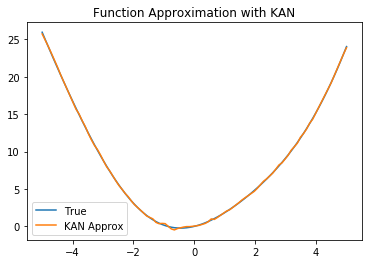

In [5]:

# Data: f(x) = sin(x) + x^2
x = torch.linspace(-5, 5, 100).unsqueeze(1)
y = torch.sin(x) + x**2

# Model and optimizer
model = KAN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Plot results
with torch.no_grad():
    y_out = model(x)
plt.plot(x.numpy(), y.numpy(), label='True')
plt.plot(x.numpy(), y_out.numpy(), label='KAN Approx')
plt.legend()
plt.title("Function Approximation with KAN")
plt.show()

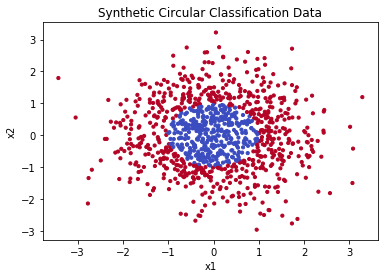

In [6]:


# Create synthetic data
n_samples = 1000
X = torch.randn(n_samples, 2)
radii = torch.norm(X, dim=1)
Y = (radii > 1.0).float().unsqueeze(1)  # Class 1 if outside circle, else 0

# Visualize
plt.scatter(X[:, 0], X[:, 1], c=Y.squeeze(), cmap='coolwarm', s=10)
plt.title("Synthetic Circular Classification Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [7]:
class KANClassifier(nn.Module):
    def __init__(self, in_features=2, hidden_dim=10):
        super().__init__()
        self.layer1 = KANLayer(in_features, hidden_dim)
        self.layer2 = KANLayer(hidden_dim, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        return torch.sigmoid(x)  # Output probability

In [14]:
model = KANClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

for epoch in range(1000):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, Y)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        acc = ((y_pred > 0.50) ==  (Y > 0.5)).float().mean().item()
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Acc: {acc:.4f}")

Epoch 0, Loss: 0.9046, Acc: 0.3970
Epoch 100, Loss: 0.1165, Acc: 0.9710
Epoch 200, Loss: 0.0664, Acc: 0.9790
Epoch 300, Loss: 0.0514, Acc: 0.9840
Epoch 400, Loss: 0.0433, Acc: 0.9860
Epoch 500, Loss: 0.0379, Acc: 0.9890
Epoch 600, Loss: 0.0335, Acc: 0.9920
Epoch 700, Loss: 0.0299, Acc: 0.9930
Epoch 800, Loss: 0.0262, Acc: 0.9930
Epoch 900, Loss: 0.0227, Acc: 0.9940


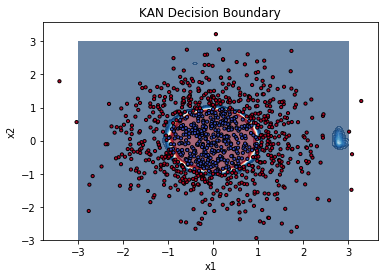

In [17]:
# Grid for plotting
import numpy as np
xx, yy = torch.meshgrid(torch.linspace(-3, 3, 100), torch.linspace(-3, 3, 100))
grid = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)

with torch.no_grad():
    probs = model(grid).reshape(100, 100)

plt.contourf(xx.numpy(), yy.numpy(), probs.numpy(), levels=50, cmap='RdBu', alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=Y.squeeze(), cmap='coolwarm', edgecolor='k', s=10)
plt.title("KAN Decision Boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()